# **可解釋 AI (XAI)**
此份程式碼會介紹如何使用套件快速觀看模型的可解釋性結果。

In [1]:
!pip install tf_keras_vis

## 匯入套件

In [2]:
import numpy as np
import cv2
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import cm

# 經典模型相關套件
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# 可解釋性模型相關套件
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam

## 載入模型

In [3]:
model = VGG16(include_top=True,  # 是否要包含分類器
              weights='imagenet',  # 在 imagenet 資料集上訓練的權重值
              input_shape=(224, 224, 3),
              classes=1000)  # 分類數目
model.summary()

2023-03-16 09:54:47.132643: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 09:54:47.793748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# upload Data
!wget -q https://github.com/TA-aiacademy/course_3.0/releases/download/CVCNN_Data/CVCNN_part4.zip
!unzip -q CVCNN_part4

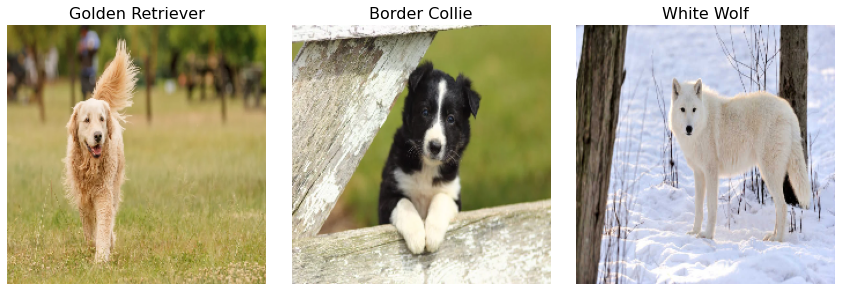

In [5]:
# Load images
img1 = cv2.imread('Golden_Retriever.jpg')
img2 = cv2.imread('Border_Collie.jpg')
img3 = cv2.imread('White_Wolf.jpg')

image_titles = ['Golden Retriever', 'Border Collie', 'White Wolf']
images = []
for i, img in enumerate([img1, img2, img3]):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(cv2.resize(img, (224, 224)))
images = np.array(images)  # shape: (3, 224, 224, 3)

# Preparing input data for VGG16
X = preprocess_input(images)

# Plot images
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Model modifier, Score function and Render

當 softmax 用於模型的最後一層時，可能會阻礙注意力圖像的生成，因此需替換成線性激活函數。

然後，**必須** 定義 score 函式返回目標分數的分數函數 (對應類別的得分值)。

- [IMAGENET 1000 Class List](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)

In [6]:
def model_modifier_function(cloned_model):
    # Convert last activation from softmax to linear
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [7]:
def score_function(output):
    # output.shape: (samples, classes)
    # Golden Retriever: 207
    # Border Collie: 232
    # White Wolf: 270
    return (output[0][207], output[1][232], output[2][270])

In [8]:
def images_plot(image_titles, images_array, visualize_cam):
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(visualize_cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(images_array[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

## GradCAM

GradCAM 是一種將輸入注意力可視化的方法。它不使用模型輸出的梯度，而是使用倒數第二層的輸出（dense layer 之前的 convolution layer）。

2023-03-16 10:02:08.920724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


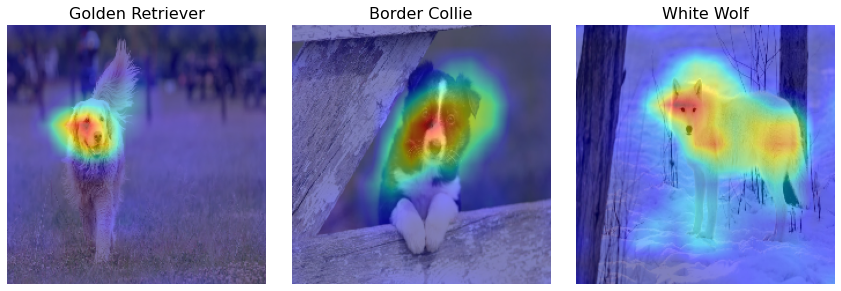

In [9]:
# Create Gradcam object
gradcam = Gradcam(model, model_modifier=model_modifier_function)

# Generate heatmap with GradCAM
cam = gradcam(score_function, X, penultimate_layer=-1)

# Plot results
images_plot(image_titles, images, visualize_cam=cam)

如結果所示，GradCAM 可以直觀地了解模型的注意力在哪裡，但是會發現，可視化的注意力並沒有完全覆蓋圖片中的類別物件。

## GradCAM++

GradCAM++ 可以為 CNN 模型預測提供更好的視覺解釋。在多個同類別物件時，GradCAM 較無法正確定位或指定位出部分物件，GranCAM++ 改善了這個問題，對於每個像素的梯度上使用加權平均，而不是全局平均。

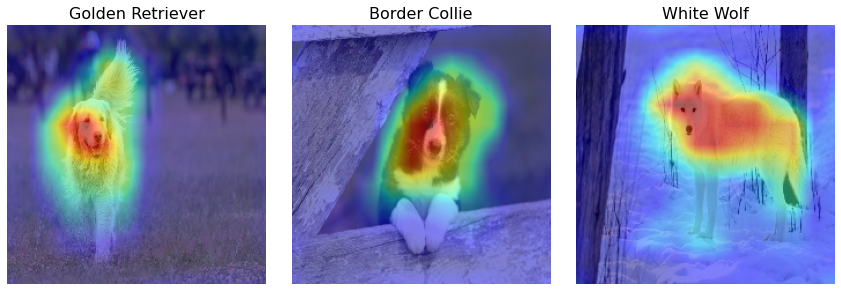

In [10]:
# Create GradCAM++ object
gradcam = GradcamPlusPlus(model, model_modifier=model_modifier_function)

# Generate heatmap with GradCAM++
cam = gradcam(score_function, X, penultimate_layer=-1)

# Plot results
images_plot(image_titles, images, cam)

## ScoreCAM

ScoreCAM 是另一種生成 Class Activation Map 的方法。 該方法的特點是不同於 GradCAM 和 GradCAM，他使用無梯度方法進行，類似從特徵圖中取得遮罩重新與輸入進到模型計算，得到所有特徵圖的權重。

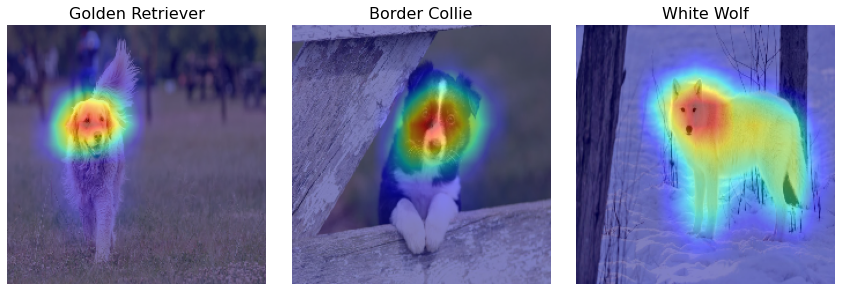

In [11]:
# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=model_modifier_function)

# Generate heatmap with ScoreCAM
cam = scorecam(score_function, X, penultimate_layer=-1)

# Plot results
images_plot(image_titles, images, cam)

## Faster-ScoreCAM

ScoreCAM 比其他方法需要更多的時間來處理。  
比 ScoreCAM 更快速的 Faster-ScorecAM 由 @tabayashi0117 設計。

https://github.com/tabayashi0117/Score-CAM/blob/master/README.md#faster-score-cam

Faster-Score-CAM 在 Score-CAM 中增加了“只使用方差較大的 channel 作為 mask 圖像”的處理。 （max_N = -1 是原始的 Score-CAM）。

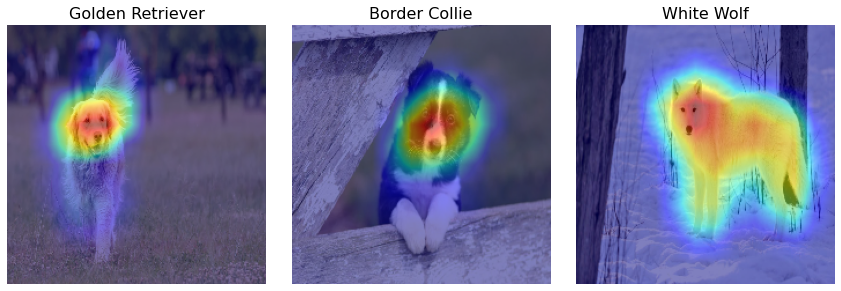

In [12]:
# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=model_modifier_function)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score_function, X, penultimate_layer=-1, max_N=10)

# Plot results
images_plot(image_titles, images, cam)

參考資源
- [reference](https://github.com/keisen/tf-keras-vis)